In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HeartAnalysis") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()
 
print("Spark version:", spark.version)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/20 16:03:49 WARN Utils: Your hostname, Ninas-macbook.local, resolves to a loopback address: 127.0.0.1; using 10.124.248.129 instead (on interface en0)
25/11/20 16:03:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/20 16:03:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.0.1


In [3]:
cvd_df = spark.read.csv("heart.csv", header=True, inferSchema=True)
cvd_df.show(5)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
+---+---+-------------+---------+-----------+---------+-

##  Preprocessing and Understanding the Data 
***
This section focuses on the initial steps of the **Exploratory Data Analysis (EDA)**.

1.  **Data Cleaning:** 
2.  **Summary Statistics:** 
3.  **Distribution Analysis:** 

1. **Data Cleaning**

    1.1 Checking for NULL values

In [9]:
from pyspark.sql.functions import col, when, count

null_counts = cvd_df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in cvd_df.columns
])

null_counts.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



    1.2 Standardizing the dataset

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


# Use a list comprehension to strip whitespace from existing column names
new_columns = [col.strip() for col in cvd_df.columns]
# Use .toDF() to create a new DataFrame with the updated names (PySpark way)
cvd_df = cvd_df.toDF(*new_columns)
print("Column names standardized (PySpark .toDF() method used).")

# 1.2 Identify and Clean Data Types
numeric_cols = ['RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

cvd_pd_df = cvd_df.toPandas()

print("\n" + "="*50)
print("## DataFrame Information (Pandas Version)")
print("="*50)
cvd_pd_df.info()

print("\n" + "="*50)
print("## Descriptive Statistics (Numeric)")
print("="*50)
print(cvd_pd_df.describe())

print("\n" + "="*50)
print("## Value Counts (Key Categorical)")
print("="*50)
for col in ['Sex', 'ChestPainType', 'HeartDisease']:
    print(f"\n--- {col} ---\n{cvd_pd_df[col].value_counts()}")


Column names standardized (PySpark .toDF() method used).

## DataFrame Information (Pandas Version)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int32  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int32  
 4   Cholesterol     918 non-null    int32  
 5   FastingBS       918 non-null    int32  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int32  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int32  
dtypes: float64(1), int32(6), object(5)
memory usage: 64.7+ KB

## Descriptive Statistics (Numeric)
              Age   RestingBP  Cholesterol   FastingBS       MaxH

    1.3 Visualising the data

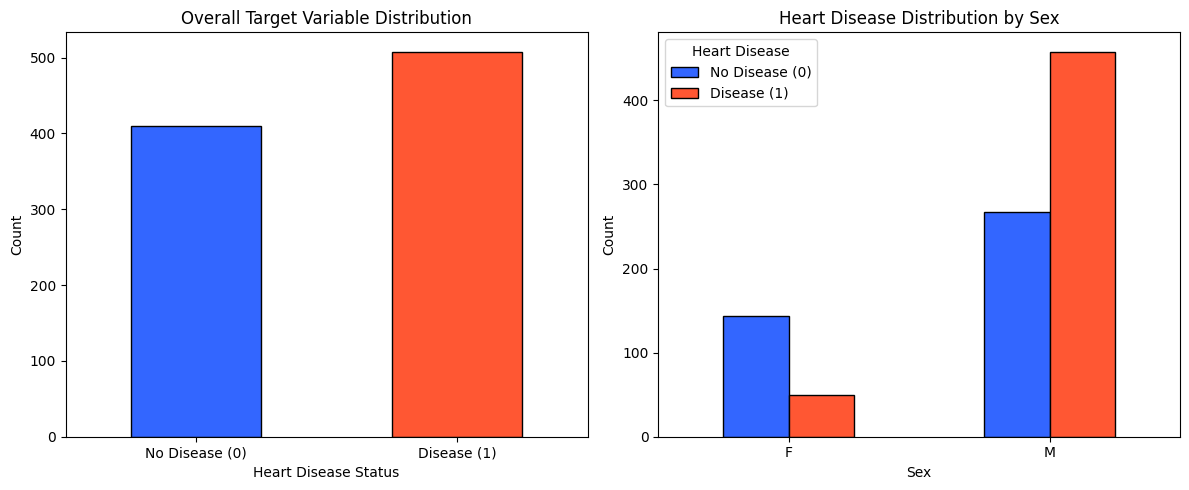

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# --- 1. PySpark to Pandas Conversion (CRITICAL) ---

# NOTE: This line MUST be executed in your notebook, selecting the two required columns:
# cvd_pd_df = cvd_df.select(col("Sex"), col("HeartDisease").cast("int")).toPandas()


# --- 2. Create the 1x2 Subplots ---

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
color_map = {0: "#3366FF", 1: "#FF5733"} # Blue (No HD), Red-Orange (HD)


# === Subplot 1: Overall Target Variable Distribution (Your Original Plot) ===

hd_counts = cvd_pd_df['HeartDisease'].value_counts().sort_index()
colors_overall = [color_map[idx] for idx in hd_counts.index]

hd_counts.plot(kind='bar', color=colors_overall, ax=axes[0], edgecolor='black')
axes[0].set_title('Overall Target Variable Distribution')
axes[0].set_xlabel('Heart Disease Status')
axes[0].set_ylabel('Count')
axes[0].set_xticks(ticks=[0, 1], labels=['No Disease (0)', 'Disease (1)'], rotation=0)


# === Subplot 2: Heart Disease Distribution by Sex (Your New Plot) ===

# Create a cross-tabulation table for plotting
sex_hd_counts = cvd_pd_df.groupby(['Sex', 'HeartDisease']).size().unstack(fill_value=0)

# Create grouped bar chart
sex_hd_counts.plot(kind='bar', stacked=False, ax=axes[1], color=[color_map[0], color_map[1]], edgecolor='black')
axes[1].set_title('Heart Disease Distribution by Sex')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(sex_hd_counts.index, rotation=0)

# Set custom legend labels
axes[1].legend(title='Heart Disease', labels=['No Disease (0)', 'Disease (1)'])

plt.tight_layout()
plt.savefig('target_distribution_by_sex.png')

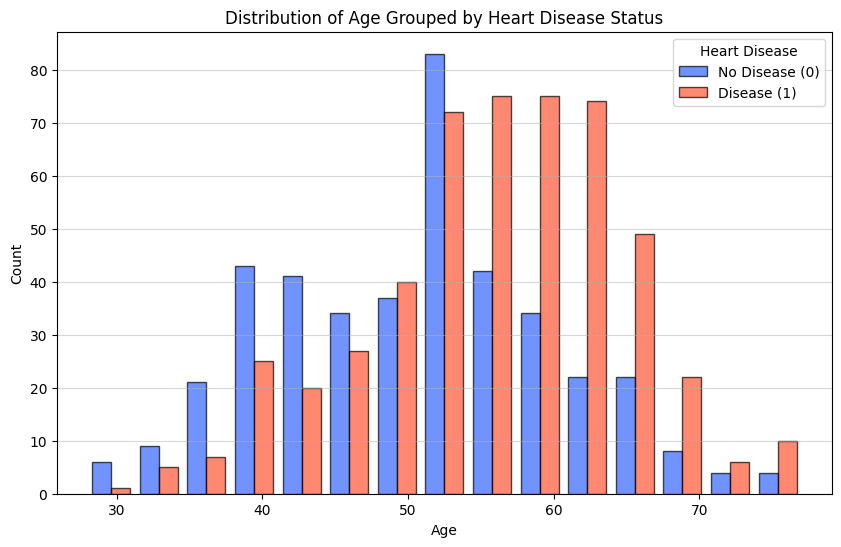

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 2. Plotting the Grouped Histogram (Matplotlib) ---

custom_colors = ["#3366FF", "#FF5733"] 

plt.figure(figsize=(10, 6))

# Separate the Age column by HeartDisease status
age_no_hd = cvd_pd_df[cvd_pd_df['HeartDisease'] == 0]['Age']
age_yes_hd = cvd_pd_df[cvd_pd_df['HeartDisease'] == 1]['Age']

# Plot the overlapping histograms
plt.hist([age_no_hd, age_yes_hd],
         bins=15, 
         stacked=False,
         color=custom_colors,
         label=['No Disease (0)', 'Disease (1)'],
         edgecolor='black',
         alpha=0.7 # Use alpha for visibility
        )

# Add title and labels
plt.title('Distribution of Age Grouped by Heart Disease Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Heart Disease')
plt.grid(axis='y', alpha=0.5)

plt.savefig('age_distribution_custom_color.png')

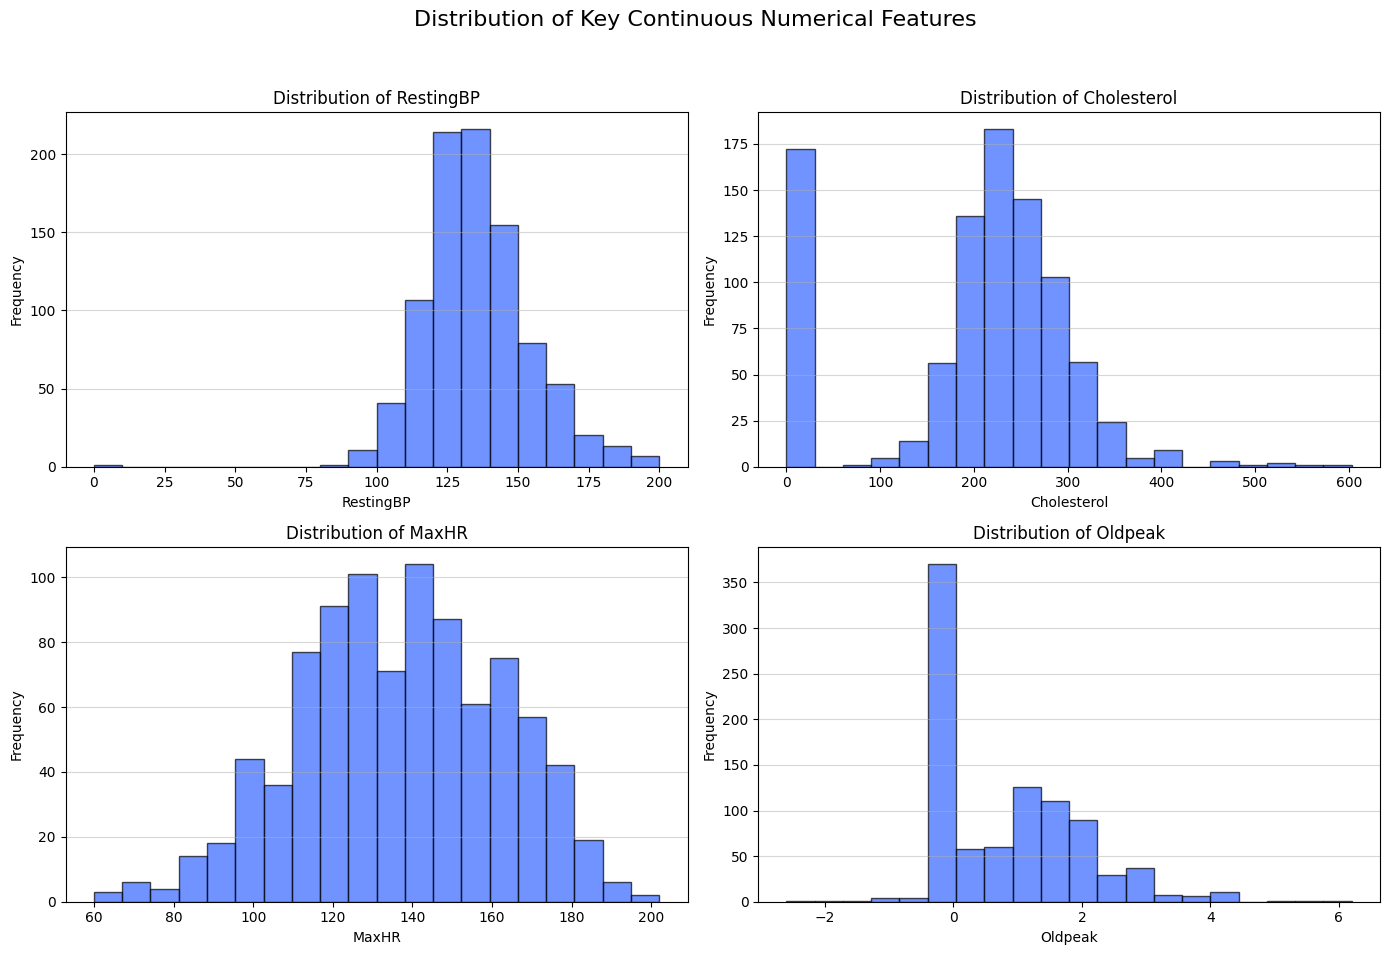

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# --- 1. PySpark to Pandas Conversion (CRITICAL FIX) ---
# This line creates and defines the 'cvd_pd_num_df' variable.
numerical_cols = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
# 👇 YOU MUST RUN THIS LINE 👇
cvd_pd_num_df = cvd_df.select(*[col(c).cast('double') for c in numerical_cols]).toPandas()


# --- 2. Create the 2x2 Histogram Subplots ---

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
custom_color = "#3366FF" 

for i, col_name in enumerate(numerical_cols):
    row = i // 2
    col_idx = i % 2
    
    # Plotting the histogram
    axes[row, col_idx].hist(cvd_pd_num_df[col_name].dropna(), 
                            bins=20, 
                            color=custom_color, 
                            edgecolor='black', 
                            alpha=0.7)
    
    axes[row, col_idx].set_title(f'Distribution of {col_name}')
    axes[row, col_idx].set_xlabel(col_name)
    axes[row, col_idx].set_ylabel('Frequency')
    axes[row, col_idx].grid(axis='y', alpha=0.5)

fig.suptitle('Distribution of Key Continuous Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('numerical_features_distribution.png')

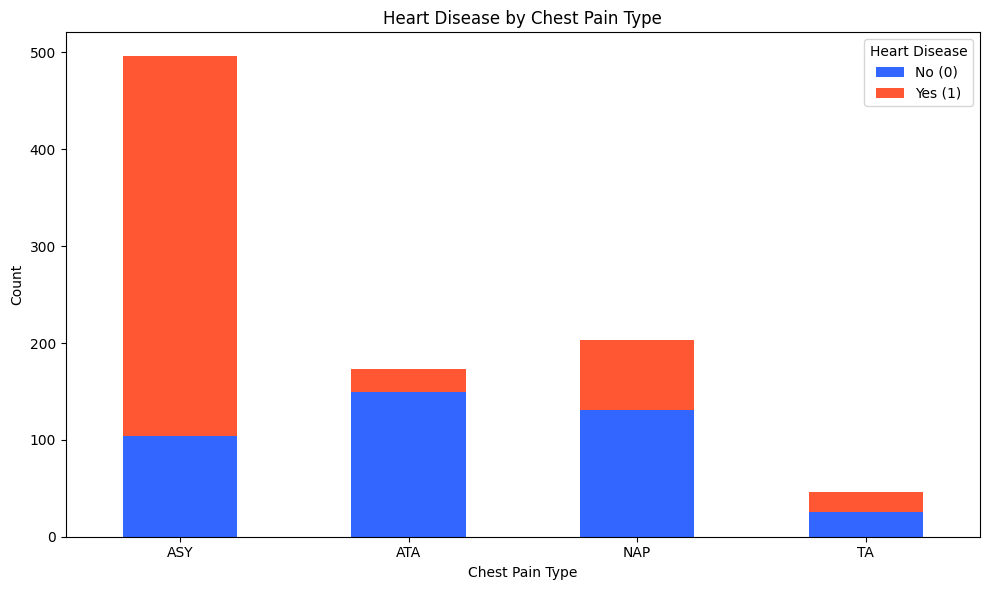

In [14]:
# 3.2 Heart Disease vs. Chest Pain Type (Stacked Bar Chart)
counts = pd.crosstab(cvd_pd_df['ChestPainType'], cvd_pd_df['HeartDisease'])

plt.figure(figsize=(10, 6))
counts.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#3366FF', '#FF5733'])
plt.title('Heart Disease by Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No (0)', 'Yes (1)'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

25/11/20 16:14:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
                                                                                

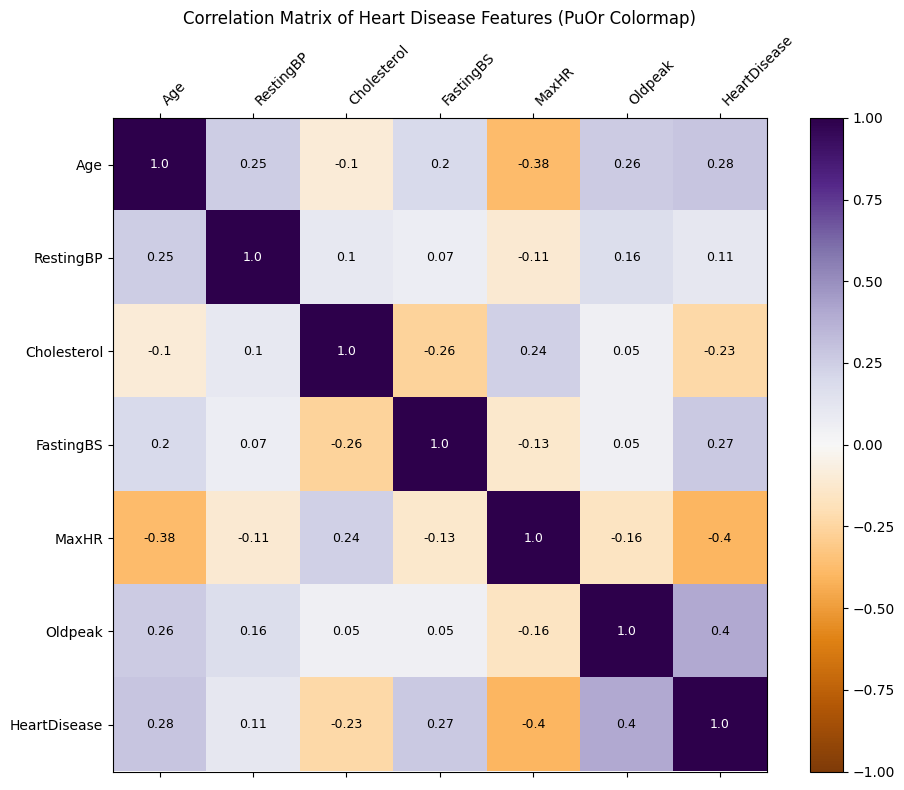

In [15]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Identify Numeric Columns and Ensure Types ---
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']

# Ensure numeric columns are cast to a numeric type (Float or Double) for correlation calculation
for col_name in numeric_cols:
    cvd_df = cvd_df.withColumn(col_name, cvd_df[col_name].cast('double'))

# --- 2. PySpark Correlation Calculation ---
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
vector_df = assembler.transform(cvd_df).select("features")
# This is the scalable PySpark step
matrix = Correlation.corr(vector_df, "features").collect()[0][0]

# --- 3. Visualization Setup (Conversion to Pandas) ---
corr_matrix_pd = pd.DataFrame(matrix.toArray(), 
                              index=numeric_cols, 
                              columns=numeric_cols)

# --- 4. Plotting the Heatmap (using Matplotlib with 'PuOr' colormap) ---

plt.figure(figsize=(10, 8))
ax = plt.gca()

# Use 'PuOr' colormap (Purple-Orange Diverging) for rich, dark colors
cax = ax.matshow(corr_matrix_pd, cmap='PuOr', vmin=-1, vmax=1)

plt.colorbar(cax)

ax.set_xticks(np.arange(len(numeric_cols)))
ax.set_yticks(np.arange(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha='left')
ax.set_yticklabels(numeric_cols)

plt.title('Correlation Matrix of Heart Disease Features (PuOr Colormap)')
plt.tight_layout()

# Annotate the values on the heatmap
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        c = round(corr_matrix_pd.iloc[i, j], 2)
        # Ensure text is readable against the background
        # Color the text white for stronger correlations (darker squares)
        text_color = 'white' if abs(c) > 0.4 else 'black' 
        ax.text(j, i, str(c), va='center', ha='center', color=text_color, fontsize=9)

plt.savefig('correlation_heatmap_puor.png')

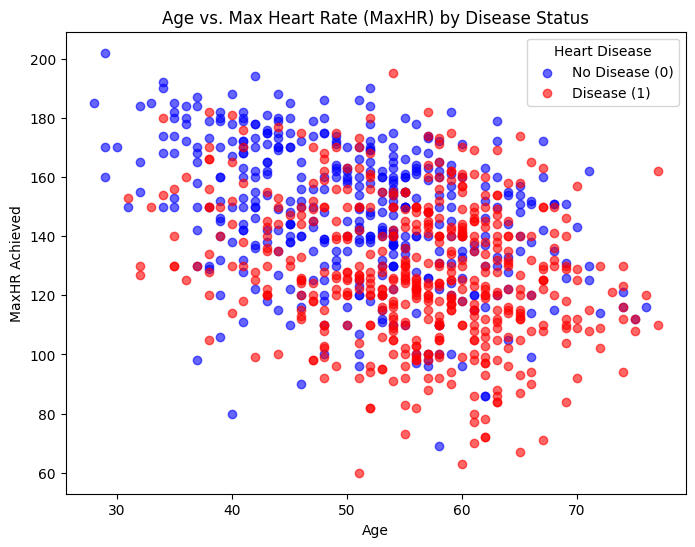

In [16]:
# 3.3 Numeric Correlation (MaxHR vs. Age, colored by HeartDisease)
plt.figure(figsize=(8, 6))
# Plot points for 'No Disease (0)'
plt.scatter(
    cvd_pd_df[cvd_pd_df['HeartDisease'] == 0]['Age'],
    cvd_pd_df[cvd_pd_df['HeartDisease'] == 0]['MaxHR'],
    label='No Disease (0)',
    color='blue',
    alpha=0.6
)
# Plot points for 'Disease (1)'
plt.scatter(
    cvd_pd_df[cvd_pd_df['HeartDisease'] == 1]['Age'],
    cvd_pd_df[cvd_pd_df['HeartDisease'] == 1]['MaxHR'],
    label='Disease (1)',
    color='red',
    alpha=0.6
)
plt.title('Age vs. Max Heart Rate (MaxHR) by Disease Status')
plt.xlabel('Age')
plt.ylabel('MaxHR Achieved')
plt.legend(title='Heart Disease')
plt.show()

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # Used here for plot type, even if running locally.

# --- 1. PySpark to Pandas Conversion (CRITICAL) ---
# NOTE: This line MUST be executed in your notebook, assuming 'cvd_df' is loaded.
# cvd_pd_df = cvd_df.select("Sex", "MaxHR", "HeartDisease").toPandas()

# Assuming cvd_pd_df is the resulting Pandas DataFrame

# --- 2. Grouped Box Plot (Matplotlib/Pandas Plotting) ---

# Customizing colors for clarity: Orange/Red for Disease (1), Blue for No Disease (0)
plot_colors = {0: "#3366FF", 1: "#FF5733"} 

plt.figure(figsize=(10, 6))

# Use the Pandas/Matplotlib plot function, grouped by Sex and Hue=HeartDisease
# Note: While using ax.boxplot() directly is possible, using pandas.DataFrame.boxplot() or 
# a simple sns.boxplot() (if available) simplifies the grouping logic. 
# We will use the matplotlib native way for maximum compatibility, manually grouping the data.

sexes = cvd_pd_df['Sex'].unique()
data_to_plot = []
labels = []
colors = []
positions = []
width = 0.35

for i, sex in enumerate(sexes):
    for hd_status in [0, 1]:
        subset = cvd_pd_df[(cvd_pd_df['Sex'] == sex) & (cvd_pd_df['HeartDisease'] == hd_status)]
        if not subset.empty:
            data_to_plot.append(subset['MaxHR'].values)
            labels.append(f'{sex} ({hd_status})')
            colors.append(plot_colors[hd_status])
            # Calculate position: 1st group at 1, 2nd group at 1 + width, 3rd group at 2, etc.
            positions.append(i * (2 * width + 0.5) + (hd_status * width))

# Draw the boxplots
box_plot = plt.boxplot(data_to_plot, 
                       positions=positions, 
                       widths=width, 
                       patch_artist=True,
                       showfliers=True) # Show outliers

# Apply colors to the boxplots
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    
# Set custom X-ticks
mean_positions = [(i * (2 * width + 0.5) + width / 2) for i in range(len(sexes))]
plt.xticks(mean_positions, [f'Sex: {s}' for s in sexes])

# Create a manual legend
legend_handles = [plt.Rectangle((0,0),1,1, color=plot_colors[hd]) for hd in [0, 1]]
plt.legend(legend_handles, ['No Disease (0)', 'Disease (1)'], title='Heart Disease Status')


plt.title('Distribution of Maximum Heart Rate (MaxHR) by Sex and Disease Status')
plt.xlabel('Sex')
plt.ylabel('Max Heart Rate Achieved (MaxHR)')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

plt.savefig('maxhr_grouped_boxplot.png')

ModuleNotFoundError: No module named 'seaborn'

## Resilient Distributed Datasets (RDDs)
***
This section demonstrates our proficiency with **RDDs**, the fundamental, fault-tolerant collection in Spark. We use low-level RDD transformations and actions to ensure **scalability** and **performance**:

* **Distributed Aggregation:** Using `map`, `filter`, and `reduceByKey`.
* **Unstructured Processing:** Employing **`flatMap`** to tokenize data.
* **Optimization:** Implementing **`.cache()`** for persistence and the **`aggregate`** action for efficient, single-pass computation.

In [18]:
# Convert DataFrame to RDD
cvd_rdd = cvd_df.rdd

In [16]:
# Compute average cholesterol per age group (filter, map, reduceByKey)

# 1. Filter out missing cholesterol values (unary: filter)
clean_rdd = cvd_rdd.filter(lambda r: r.Cholesterol > 0)

# 2. Convert age into age groups (unary: map)
grouped = clean_rdd.map(lambda r: ((r.Age // 10) * 10, (r.Cholesterol, 1)))
# e.g. (50, (250, 1)) → age group 50–59

# 3. Reduce by key (pair transformation)
reduced = grouped.reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1]))

# 4. Compute final averages
avg_chol_by_age_group = reduced.map(lambda x: (x[0], x[1][0] / x[1][1]))

print(avg_chol_by_age_group.collect())

[(40.0, 241.717277486911), (30.0, 233.87878787878788), (50.0, 246.5808580858086), (60.0, 252.3375796178344), (20.0, 210.5), (70.0, 228.84)]


In [17]:
# Combine all older males and older females into one RDD of “older patients”. (filter, union)

older_males = cvd_rdd.filter(lambda r: r.Sex == "M" and r.Age > 50)
older_females = cvd_rdd.filter(lambda r: r.Sex == "F" and r.Age > 50)

older_patients = older_males.union(older_females)

print("Older patients (via union):")
print(older_patients.take(10))



Older patients (via union):
[Row(Age=54.0, Sex='M', ChestPainType='NAP', RestingBP=150.0, Cholesterol=195.0, FastingBS=0.0, RestingECG='Normal', MaxHR=122.0, ExerciseAngina='N', Oldpeak=0.0, ST_Slope='Up', HeartDisease=0.0), Row(Age=54.0, Sex='M', ChestPainType='ATA', RestingBP=110.0, Cholesterol=208.0, FastingBS=0.0, RestingECG='Normal', MaxHR=142.0, ExerciseAngina='N', Oldpeak=0.0, ST_Slope='Up', HeartDisease=0.0), Row(Age=58.0, Sex='M', ChestPainType='ATA', RestingBP=136.0, Cholesterol=164.0, FastingBS=0.0, RestingECG='ST', MaxHR=99.0, ExerciseAngina='Y', Oldpeak=2.0, ST_Slope='Flat', HeartDisease=1.0), Row(Age=60.0, Sex='M', ChestPainType='ASY', RestingBP=100.0, Cholesterol=248.0, FastingBS=0.0, RestingECG='Normal', MaxHR=125.0, ExerciseAngina='N', Oldpeak=1.0, ST_Slope='Flat', HeartDisease=1.0), Row(Age=53.0, Sex='M', ChestPainType='ASY', RestingBP=124.0, Cholesterol=260.0, FastingBS=0.0, RestingECG='ST', MaxHR=112.0, ExerciseAngina='Y', Oldpeak=3.0, ST_Slope='Flat', HeartDisease=

In [18]:
# Count patients per ChestPainType (map, reduceByKey)

cp_counts = cvd_rdd.map(lambda row: (row.ChestPainType, 1)) \
                   .reduceByKey(lambda a, b: a + b)

print("Number of patients per ChestPainType:")
for cp, count in cp_counts.collect():
    print(f"{cp}: {count}")

Number of patients per ChestPainType:
ATA: 173
NAP: 203
ASY: 496
TA: 46


In [19]:
# Average max heart rate achieved by sex (map, reduceByKey)

# Map to (Sex, (MaxHR, 1))
sex_maxhr = cvd_rdd.map(lambda row: (row.Sex, (row.MaxHR, 1)))

# Reduce by key to sum MaxHR and counts
sex_maxhr_sum = sex_maxhr.reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1]))

# Compute average
avg_maxhr_by_sex = sex_maxhr_sum.mapValues(lambda x: x[0]/x[1])

print("Average MaxHR by Sex:")
for sex, avg in avg_maxhr_by_sex.collect():
    print(f"{sex}: {avg:.2f}")

Average MaxHR by Sex:
M: 134.33
F: 146.14


In [20]:
#Filter high-risk patients (filter)

# High-risk: FastingBS > 120 or ExerciseAngina == 'Y'
high_risk_rdd = cvd_rdd.filter(lambda row: row.FastingBS == 1 or row.ExerciseAngina == 'Y')

print(f"Total high-risk patients: {high_risk_rdd.count()}")


Total high-risk patients: 487


In [21]:
# Top 5 oldest patients with heart disease (filter)

heart_patients = cvd_rdd.filter(lambda row: row.HeartDisease == 1)
top_oldest = heart_patients.takeOrdered(5, key=lambda row: -row.Age)

print("Top 5 oldest patients with heart disease:")
for row in top_oldest:
    print(f"Age: {row.Age}, Sex: {row.Sex}, ChestPainType: {row.ChestPainType}")


Top 5 oldest patients with heart disease:
Age: 77.0, Sex: M, ChestPainType: ASY
Age: 77.0, Sex: M, ChestPainType: ASY
Age: 76.0, Sex: M, ChestPainType: NAP
Age: 75.0, Sex: M, ChestPainType: ASY
Age: 75.0, Sex: M, ChestPainType: ASY


In [22]:
# Distribution of ChestPainType among high-risk patients

cp_high_risk = high_risk_rdd.map(lambda row: (row.ChestPainType, 1)) \
                             .reduceByKey(lambda a, b: a + b)

print("ChestPainType counts among high-risk patients:")
for cp, count in cp_high_risk.collect():
    print(f"{cp}: {count}")


ChestPainType counts among high-risk patients:


ASY: 359
ATA: 31
NAP: 79
TA: 18


In [23]:
# Aggregate over RestingBP: (Sum_BP, Count)
# Note the use of .cache() to persist the RDD in memory for fast reuse.

# Cache the RDD to speed up subsequent actions
cvd_rdd.cache()

# Define the accumulator (zero value): (sum_BP, count)
zero_value = (0, 0)

# Define the sequence operation (seqOp)
# Applied within each partition: (current_sum, current_count) + new_row.RestingBP
def seqOp(accumulator, row):
    return (accumulator[0] + row.RestingBP, accumulator[1] + 1)

# Define the combine operation (combOp)
# Applied between partitions: (sum_A, count_A) + (sum_B, count_B)
def combOp(acc1, acc2):
    return (acc1[0] + acc2[0], acc1[1] + acc2[1])

# Perform the aggregation
total_bp_sum, total_count = cvd_rdd.aggregate(zero_value, seqOp, combOp)

print("\nRDD Persistence and Aggregate Demonstration:")
print(f"Total RestingBP Sum (via aggregate): {total_bp_sum}")
print(f"Total Patient Count (via aggregate): {total_count}")
print(f"Average RestingBP: {total_bp_sum / total_count:.2f}")

cvd_rdd.unpersist() # Clean up persistence
# RDD Note: The aggregate function is one of the most powerful and efficient tools for complex, single-pass calculations.


RDD Persistence and Aggregate Demonstration:
Total RestingBP Sum (via aggregate): 121540.0
Total Patient Count (via aggregate): 918
Average RestingBP: 132.40


MapPartitionsRDD[44] at javaToPython at NativeMethodAccessorImpl.java:0

## DataFrames & Spark SQL

We use **Spark DataFrames** to work with our dataset in a structured, table-like format.  
They provide schema information, optimized execution, and easy transformations.

After loading the data as a DataFrame, we can also register it as a temporary view and run **Spark SQL** queries directly, just like a database:

```python
cvd_df.createOrReplaceTempView("heart")
spark.sql("SELECT Age, Cholesterol FROM heart WHERE Age > 50").show()


In [24]:
# Printing the schema

cvd_df.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: double (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- FastingBS: double (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: double (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: double (nullable = true)



In [25]:
#Select with dataframe

cvd_df.select("Age", "Sex", "HeartDisease").show(5)


+----+---+------------+
| Age|Sex|HeartDisease|
+----+---+------------+
|40.0|  M|         0.0|
|49.0|  F|         1.0|
|37.0|  M|         0.0|
|48.0|  F|         1.0|
|54.0|  M|         0.0|
+----+---+------------+
only showing top 5 rows


In [26]:
#Select with Spark SQL

cvd_df.createOrReplaceTempView("cvd")
spark.sql("""
    SELECT Age, Sex, HeartDisease
    FROM cvd
    LIMIT 5
""").show()

# Both give the same output; SQL is concise for analysts, DSL is good for Python developers.

+----+---+------------+
| Age|Sex|HeartDisease|
+----+---+------------+
|40.0|  M|         0.0|
|49.0|  F|         1.0|
|37.0|  M|         0.0|
|48.0|  F|         1.0|
|54.0|  M|         0.0|
+----+---+------------+



In [27]:
# Filtering with dataframes

cvd_df.filter(cvd_df.Age > 50).show(5)

+----+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+----+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|54.0|  M|          NAP|    150.0|      195.0|      0.0|    Normal|122.0|             N|    0.0|      Up|         0.0|
|54.0|  M|          ATA|    110.0|      208.0|      0.0|    Normal|142.0|             N|    0.0|      Up|         0.0|
|58.0|  M|          ATA|    136.0|      164.0|      0.0|        ST| 99.0|             Y|    2.0|    Flat|         1.0|
|54.0|  F|          ATA|    120.0|      273.0|      0.0|    Normal|150.0|             N|    1.5|    Flat|         0.0|
|60.0|  M|          ASY|    100.0|      248.0|      0.0|    Normal|125.0|             N|    1.0|    Flat|         1.0|
+----+---+-------------+---------+-----------+--

In [28]:
# Filtering with Spark SQL

spark.sql("""
    SELECT *
    FROM cvd
    WHERE Age > 50
    LIMIT 5
""").show()

# Lazy evaluation: Spark doesn’t compute until an action like show() or count() is called.

+----+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+----+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|54.0|  M|          NAP|    150.0|      195.0|      0.0|    Normal|122.0|             N|    0.0|      Up|         0.0|
|54.0|  M|          ATA|    110.0|      208.0|      0.0|    Normal|142.0|             N|    0.0|      Up|         0.0|
|58.0|  M|          ATA|    136.0|      164.0|      0.0|        ST| 99.0|             Y|    2.0|    Flat|         1.0|
|54.0|  F|          ATA|    120.0|      273.0|      0.0|    Normal|150.0|             N|    1.5|    Flat|         0.0|
|60.0|  M|          ASY|    100.0|      248.0|      0.0|    Normal|125.0|             N|    1.0|    Flat|         1.0|
+----+---+-------------+---------+-----------+--

In [29]:
# Aggregation with DataFrames

from pyspark.sql.functions import avg

cvd_df.groupBy("Sex").agg(avg("MaxHR").alias("avg_maxhr")).show()

+---+------------------+
|Sex|         avg_maxhr|
+---+------------------+
|  F|146.13989637305698|
|  M|134.32551724137932|
+---+------------------+



In [30]:
# Aggregation with Spark SQL

spark.sql("""
    SELECT Sex, AVG(MaxHR) AS avg_maxhr
    FROM cvd
    GROUP BY Sex
""").show()


+---+------------------+
|Sex|         avg_maxhr|
+---+------------------+
|  F|146.13989637305698|
|  M|134.32551724137932|
+---+------------------+



In [35]:

spark.sql("""
    SELECT a.Age AS Age1, b.Age AS Age2, a.ChestPainType
    FROM cvd a
    JOIN cvd b ON a.ChestPainType = b.ChestPainType
    LIMIT 5
""").show()


+----+----+-------------+
|Age1|Age2|ChestPainType|
+----+----+-------------+
|40.0|57.0|          ATA|
|40.0|41.0|          ATA|
|40.0|55.0|          ATA|
|40.0|56.0|          ATA|
|40.0|56.0|          ATA|
+----+----+-------------+



In [32]:
from pyspark.sql.functions import *

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Load data
cvd_df = spark.read.csv("heart.csv", header=True, inferSchema=True)

# Categorical + numeric columns
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
numeric_cols = ["Age","RestingBP","Cholesterol","FastingBS","MaxHR","Oldpeak"]

# Index and encode categoricals
indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx") for c in categorical_cols]
encoder = OneHotEncoder(inputCols=[c+"_idx" for c in categorical_cols],
                        outputCols=[c+"_ohe" for c in categorical_cols])

# Assemble features
assembler = VectorAssembler(
    inputCols=numeric_cols + [c+"_ohe" for c in categorical_cols],
    outputCol="features"
)

# Classifier
lr = LogisticRegression(featuresCol="features", labelCol="HeartDisease")

# Pipeline
pipeline = Pipeline(stages=indexers + [encoder, assembler, lr])

# Train/test split
train_df, test_df = cvd_df.randomSplit([0.7, 0.3], seed=42)

# Fit
model = pipeline.fit(train_df)

# Predict
predictions = model.transform(test_df)
predictions.select("features", "HeartDisease", "prediction", "probability").show(5, truncate=False)

# Evaluation
evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("AUC =", auc)


25/11/18 16:01:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------------------------------------------------------+------------+----------+-----------------------------------------+
|features                                                            |HeartDisease|prediction|probability                              |
+--------------------------------------------------------------------+------------+----------+-----------------------------------------+
|[29.0,130.0,204.0,0.0,202.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0]|0           |0.0       |[0.961998782559761,0.03800121744023899]  |
|[31.0,120.0,270.0,0.0,153.0,1.5,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0]|1           |1.0       |[0.067147169856666,0.932852830143334]    |
|[32.0,118.0,529.0,0.0,130.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0]|1           |1.0       |[0.36340886325866634,0.6365911367413337] |
|[32.0,110.0,225.0,0.0,184.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0]|0           |0.0       |[0.9698550678570371,0.030144932142962877]|
|[33.0,120.0,298.0,0.0,185.0,0.0,1.0,0.0,

In [37]:
# Hyperparameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0, 0.1, 0.3])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cv_model = cv.fit(train_df)

cv_predictions = cv_model.transform(test_df)
print("Tuned AUC =", evaluator.evaluate(cv_predictions))



Tuned AUC = 0.9257063387498168


In [36]:
# Random forest

# Remove Logistic Regression output columns before training RF
train_prepared_rf = train_prepared.drop("prediction", "probability", "rawPrediction")
test_prepared_rf = test_prepared.drop("prediction", "probability", "rawPrediction")

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="HeartDisease", featuresCol="features")

rf_model = rf.fit(train_prepared_rf)

rf_pred = rf_model.transform(test_prepared_rf)

print("RF AUC =", evaluator.evaluate(rf_pred))




NameError: name 'train_prepared' is not defined

In [35]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# SVM
svm = LinearSVC(featuresCol="features", labelCol="HeartDisease", maxIter=50, regParam=0.1)

# Pipeline
pipeline_svm = Pipeline(stages=indexers + [encoder, assembler, svm])

# Fit
svm_model = pipeline_svm.fit(train_df)

# Predict
predictions_svm = svm_model.transform(test_df)
predictions_svm.select("features", "HeartDisease", "rawPrediction", "prediction").show(5, truncate=False)

# Evaluate AUC using rawPrediction column
evaluator = BinaryClassificationEvaluator(
    labelCol="HeartDisease",
    rawPredictionCol="rawPrediction",  # use raw margin
    metricName="areaUnderROC"
)

auc_svm = evaluator.evaluate(predictions_svm)
print("SVM AUC =", auc_svm)


+--------------------------------------------------------------------+------------+----------------------------------------------+----------+
|features                                                            |HeartDisease|rawPrediction                                 |prediction|
+--------------------------------------------------------------------+------------+----------------------------------------------+----------+
|[29.0,130.0,204.0,0.0,202.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0]|0           |[1.8943245148178258,-1.8943245148178258]      |0.0       |
|[31.0,120.0,270.0,0.0,153.0,1.5,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0]|1           |[-1.1675074949492579,1.1675074949492579]      |1.0       |
|[32.0,118.0,529.0,0.0,130.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0]|1           |[-0.0027013365084830876,0.0027013365084830876]|1.0       |
|[32.0,110.0,225.0,0.0,184.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0]|0           |[1.8290669620521338,-1.8290669620521338]      |0.0       |
|[33.0